# 🧪 Classic Super-Resolution Techniques
This notebook presents practical implementations of five classical super-resolution techniques:
1. Bilinear, Bicubic, Area and Lanczos interpolation
2. Iterative Back-Projection (IBP)
3. Non-Local Means Super-Resolution
4. Edge-Guided Interpolation (EGI)
5. Frequency Domain Extrapolation

In [1]:
import os
import sys
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

from SRModels.classic_super_resolution_algorithms.profiling_methods import *
from SRModels.classic_super_resolution_algorithms.classic_algorithms import *
from SRModels.classic_super_resolution_algorithms.visualization_methods import *

## Tracking structures for profiling data

In [2]:
algorithms = ['bilinear','bicubic','area','lanczos','ibp','nlm','egi','freq']

time_stats = {
    'bilinear': [], 'bicubic': [], 'area': [], 'lanczos': [],
    'ibp': [], 'nlm': [], 'egi': [], 'freq': []
}
memory_stats = {k: [] for k in time_stats}
psnr_stats = {k: [] for k in time_stats}
ssim_stats = {k: [] for k in time_stats}
mae_stats = {k: [] for k in time_stats}
rmse_stats = {k: [] for k in time_stats}
throughput_stats = {k: [] for k in time_stats}  # MP/s per image (aún sin poblar)
gradient_mse_stats = {k: [] for k in time_stats}
epi_stats = {k: [] for k in time_stats}
hf_energy_ratio_stats = {k: [] for k in time_stats}
kl_luma_stats = {k: [] for k in time_stats}
kl_color_stats = {k: [] for k in time_stats}

# Time & Memory jitter / variance
time_jitter = {}
time_variance = {}
mem_variance = {}

HF_RADIUS_FRACTION = 0.6  # threshold for high-frequency mask
EPS_NUM = 1e-9

example_index = 0
vis = None         
ibp_example = None 
nlm_example = None 
egi_example = None 
freq_example = None

# Plot colors
colors = {
    'bilinear': '#4c72b0',
    'bicubic':  '#55a868',
    'area':     '#c44e52',
    'lanczos':  '#8172b2',
    'ibp':      '#ccb974',
    'nlm':      '#64b5cd',
    'egi':      '#8c8c8c',
    'freq':     '#937860',
}

# Directory for saving result figures
RESULTS_DIR = Path('classic_algorithms_results')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

## Loading dataset

In [3]:
HR_DIR = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/HR/low_z_offset"))
LR_DIR = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/LR/low_z_offset"))

hr_paths = sorted(glob.glob(os.path.join(HR_DIR, '*.png')))
lr_paths = sorted(glob.glob(os.path.join(LR_DIR, '*.png')))

assert len(hr_paths) == len(lr_paths) and len(hr_paths) > 0, "No HR/LR pairs found or the number does not match"

# Load all images into memory (if possible); otherwise, process in streaming
hr_images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in hr_paths]
lr_images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in lr_paths]

## Main Loop

In [4]:
for idx, (hr_img, lr_img) in enumerate(zip(hr_images, lr_images)):
    # -------------------- #
    # INTERPOLATION FAMILY #
    # -------------------- #
    h, w = hr_img.shape[:2]

    # Bilinear
    def _bilinear():
        return interpolate_bilinear(lr_img, (w, h))
    bilinear, bilinear_time = time_algorithm(_bilinear)
    _, bilinear_mem = memory_algorithm(_bilinear)
    time_stats['bilinear'].append(bilinear_time)
    memory_stats['bilinear'].append(bilinear_mem)

    # Bicubic
    def _bicubic():
        return interpolate_bicubic(lr_img, (w, h))
    bicubic, bicubic_time = time_algorithm(_bicubic)
    _, bicubic_mem = memory_algorithm(_bicubic)
    time_stats['bicubic'].append(bicubic_time)
    memory_stats['bicubic'].append(bicubic_mem)

    # Area
    def _area():
        return interpolate_area(lr_img, (w, h))
    area, area_time = time_algorithm(_area)
    _, area_mem = memory_algorithm(_area)
    time_stats['area'].append(area_time)
    memory_stats['area'].append(area_mem)

    # Lanczos
    def _lanczos():
        return interpolate_lanczos(lr_img, (w, h))
    lanczos, lanczos_time = time_algorithm(_lanczos)
    _, lanczos_mem = memory_algorithm(_lanczos)
    time_stats['lanczos'].append(lanczos_time)
    memory_stats['lanczos'].append(lanczos_mem)

    # Metrics (color) for interpolation outputs
    hr_f = hr_img.astype(np.float32) / 255.0
    for name, sr_img in [("bilinear", bilinear), ("bicubic", bicubic), ("area", area), ("lanczos", lanczos)]:
        sr_f = sr_img.astype(np.float32) / 255.0
        psnr_stats[name].append(psnr(hr_f, sr_f, data_range=1.0))
        ssim_stats[name].append(ssim(hr_f, sr_f, channel_axis=2, data_range=1.0))
        # Extended metrics (color)
        mae_stats[name].append(mae(hr_img, sr_img))
        rmse_stats[name].append(rmse(hr_img, sr_img))
        gradient_mse_stats[name].append(gradient_mse(hr_img, sr_img))
        epi_stats[name].append(epi(hr_img, sr_img))
        hf_energy_ratio_stats[name].append(
            hf_energy_ratio(cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY),
                            cv2.cvtColor(sr_img, cv2.COLOR_RGB2GRAY),
                            radius_frac=HF_RADIUS_FRACTION)
        )
        kl_luma_stats[name].append(
            kl_divergence(cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY),
                          cv2.cvtColor(sr_img, cv2.COLOR_RGB2GRAY))
        )
        kl_color_stats[name].append(kl_divergence_color(hr_img, sr_img))

    # ---------------- #
    # ADVANCED METHODS #
    # ---------------- #
    hr_g = cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY)
    lr_g = cv2.cvtColor(lr_img, cv2.COLOR_RGB2GRAY)

    # IBP
    def ibp_run():
        return back_projection(hr_g, lr_g, iterations=10)
    ibp_res, ibp_time = time_algorithm(ibp_run)
    _, ibp_mem = memory_algorithm(ibp_run)
    time_stats['ibp'].append(ibp_time)
    memory_stats['ibp'].append(ibp_mem)

    # NLM
    def nlm_run():
        return non_local_means(hr_g, lr_g)
    nlm_res, nlm_time = time_algorithm(nlm_run)
    _, nlm_mem = memory_algorithm(nlm_run)
    time_stats['nlm'].append(nlm_time)
    memory_stats['nlm'].append(nlm_mem)

    # EGI
    def egi_run():
        return edge_guided_interpolation(hr_g, lr_g)
    egi_res, egi_time = time_algorithm(egi_run)
    _, egi_mem = memory_algorithm(egi_run)
    time_stats['egi'].append(egi_time)
    memory_stats['egi'].append(egi_mem)

    # Frequency domain extrapolation
    def freq_run():
        return frequency_extrapolation(hr_g, lr_g)
    freq_res, freq_time = time_algorithm(freq_run)
    _, freq_mem = memory_algorithm(freq_run)
    time_stats['freq'].append(freq_time)
    memory_stats['freq'].append(freq_mem)

    if np.max(freq_res) > 0:
        freq_up_uint8 = (freq_res / np.max(freq_res) * 255.0).astype(np.uint8)
    else:
        freq_up_uint8 = freq_res.astype(np.uint8)

    # Metrics (grayscale) for advanced outputs
    data_range_nlm = hr_g.max() - hr_g.min() if hr_g.max() != hr_g.min() else 255.0
    for name, sr_g in [('ibp', ibp_res), ('nlm', nlm_res), ('egi', egi_res), ('freq', freq_up_uint8)]:
        dr = data_range_nlm if name == 'nlm' else 255.0
        psnr_stats[name].append(psnr(hr_g, sr_g, data_range=dr))
        ssim_stats[name].append(ssim(hr_g, sr_g, data_range=dr))
        mae_stats[name].append(mae(hr_g, sr_g))
        rmse_stats[name].append(rmse(hr_g, sr_g))
        gradient_mse_stats[name].append(gradient_mse(hr_g, sr_g))
        epi_stats[name].append(epi(hr_g, sr_g))
        hf_energy_ratio_stats[name].append(hf_energy_ratio(hr_g, sr_g, radius_frac=HF_RADIUS_FRACTION))
        kl_luma_stats[name].append(kl_divergence(hr_g, sr_g))
        kl_color_stats[name].append(np.nan)  # Not applicable for grayscale

    # Store example artifacts once (chosen by example_index)
    if idx == example_index:
        vis = (hr_img, lr_img, bilinear, bicubic, area, lanczos)
        ibp_example = (hr_g, lr_g, ibp_res)
        nlm_example = (hr_g, nlm_res)
        egi_example = (hr_g, lr_g, egi_res)
        freq_example = (hr_g, freq_up_uint8)

In [5]:
for alg in time_stats.keys():
    t_arr = time_stats.get(alg, [])
    if len(t_arr) > 1 and np.mean(t_arr) > 0:
        time_jitter[alg] = float(np.std(t_arr, ddof=1) / np.mean(t_arr))
        time_variance[alg] = float(np.var(t_arr, ddof=1))
    else:
        time_jitter[alg] = np.nan
        time_variance[alg] = np.nan
        
    m_arr = memory_stats.get(alg, [])
    if len(m_arr) > 1:
        mem_variance[alg] = float(np.var(m_arr, ddof=1))
    else:
        mem_variance[alg] = np.nan

psnr_ci = {alg: bootstrap_ci(vals) for alg, vals in psnr_stats.items()}
ssim_ci = {alg: bootstrap_ci(vals) for alg, vals in ssim_stats.items()}

# --- Build aggregated per-algorithm summary ---
metric_summary = {}
for alg in time_stats.keys():
    time_stats_alg = compute_summary_stats(time_stats.get(alg, []))
    mem_stats_alg = compute_summary_stats(memory_stats.get(alg, []))
    psnr_stats_alg = compute_summary_stats(psnr_stats.get(alg, []))
    ssim_stats_alg = compute_summary_stats(ssim_stats.get(alg, []))
    mae_stats_alg = compute_summary_stats(mae_stats.get(alg, []))
    rmse_stats_alg = compute_summary_stats(rmse_stats.get(alg, []))
    grad_stats_alg = compute_summary_stats(gradient_mse_stats.get(alg, []))
    epi_stats_alg = compute_summary_stats(epi_stats.get(alg, []))
    hf_stats_alg = compute_summary_stats(hf_energy_ratio_stats.get(alg, []))
    kl_luma_stats_alg = compute_summary_stats(kl_luma_stats.get(alg, []))
    kl_color_stats_alg = compute_summary_stats(kl_color_stats.get(alg, []))

    metric_summary[alg] = {
        'psnr_mean': psnr_stats_alg['mean'],
        'psnr_var': psnr_stats_alg['var'],
        'psnr_max': psnr_stats_alg['max'],
        'psnr_ci_low': psnr_ci[alg][0],
        'psnr_ci_high': psnr_ci[alg][1],
        'ssim_mean': ssim_stats_alg['mean'],
        'ssim_var': ssim_stats_alg['var'],
        'ssim_max': ssim_stats_alg['max'],
        'ssim_ci_low': ssim_ci[alg][0],
        'ssim_ci_high': ssim_ci[alg][1],
        'time_mean': time_stats_alg['mean'],
        'time_max': time_stats_alg['max'],
        'time_jitter': time_jitter[alg],
        'time_var': time_variance[alg],
        'memory_mean': mem_stats_alg['mean'],
        'memory_max': mem_stats_alg['max'],
        'memory_var': mem_variance[alg],
        'mae_mean': mae_stats_alg['mean'],
        'rmse_mean': rmse_stats_alg['mean'],
        'grad_mse_mean': grad_stats_alg['mean'],
        'epi_mean': epi_stats_alg['mean'],
        'hf_ratio_mean': hf_stats_alg['mean'],
        'kl_luma_mean': kl_luma_stats_alg['mean'],
        'kl_color_mean': kl_color_stats_alg['mean'],
    }

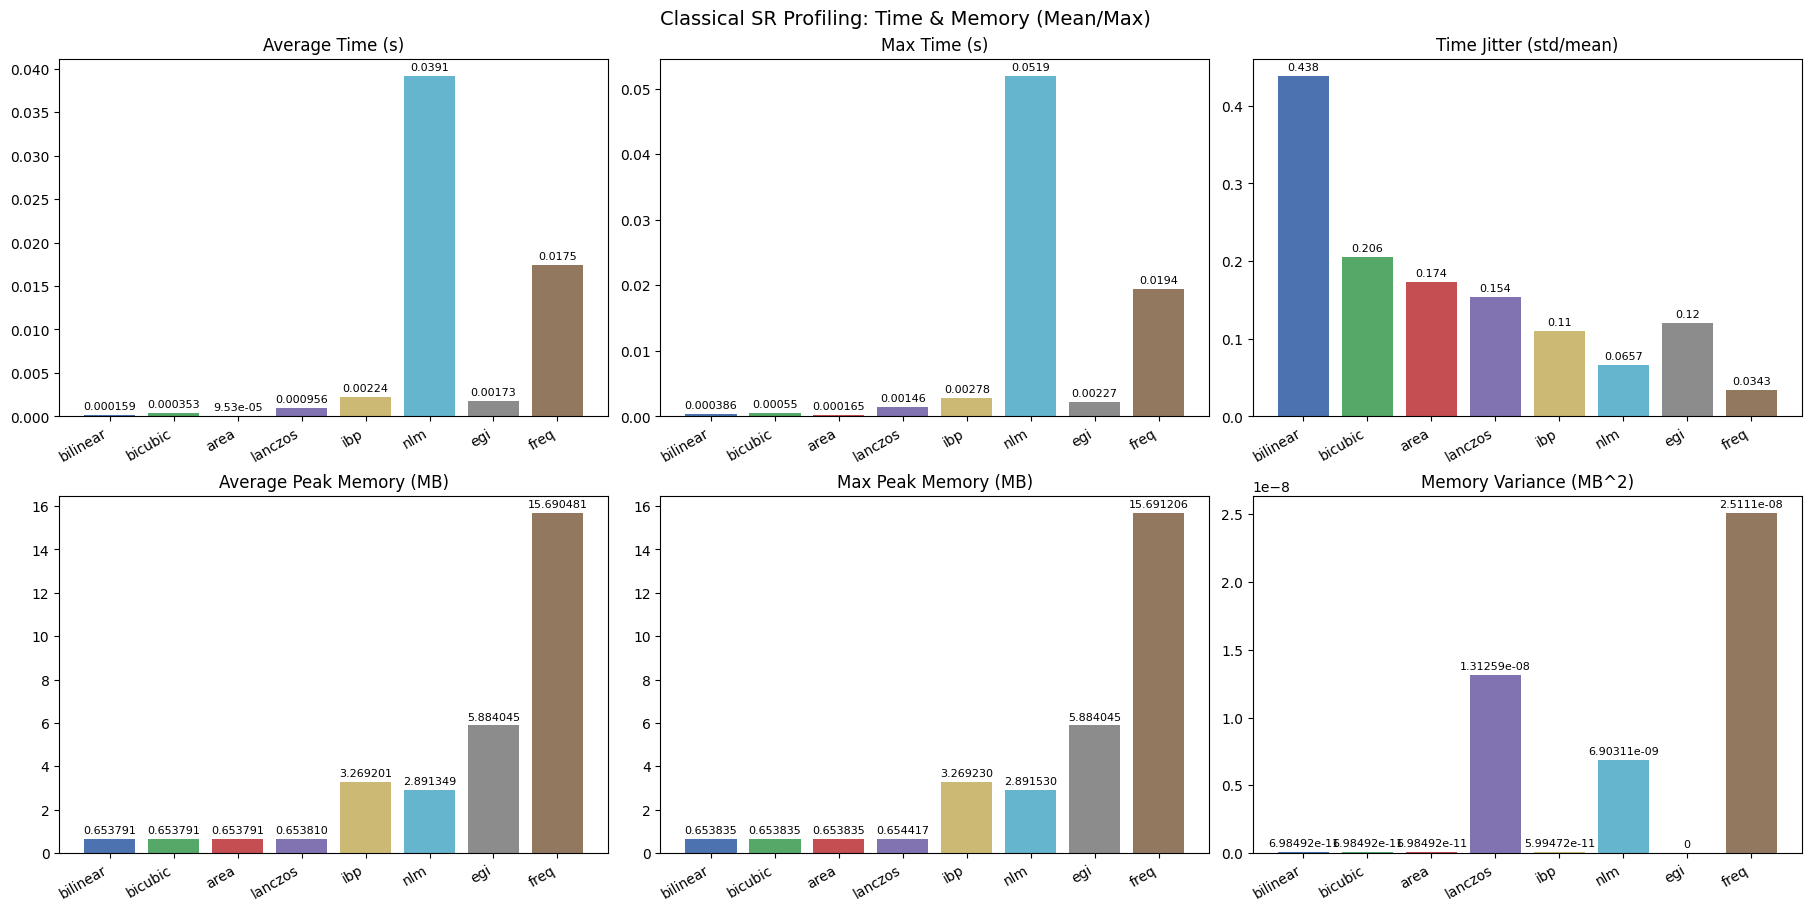

In [6]:
plot_time_memory_panels(
    metric_summary=metric_summary,
    algorithms_order=algorithms,
    colors_map=colors,
    main_title='Classical SR Profiling: Time & Memory (Mean/Max)',
    outfile=RESULTS_DIR / 'time_memory_summary.png',
    figsize=(18, 9)
)

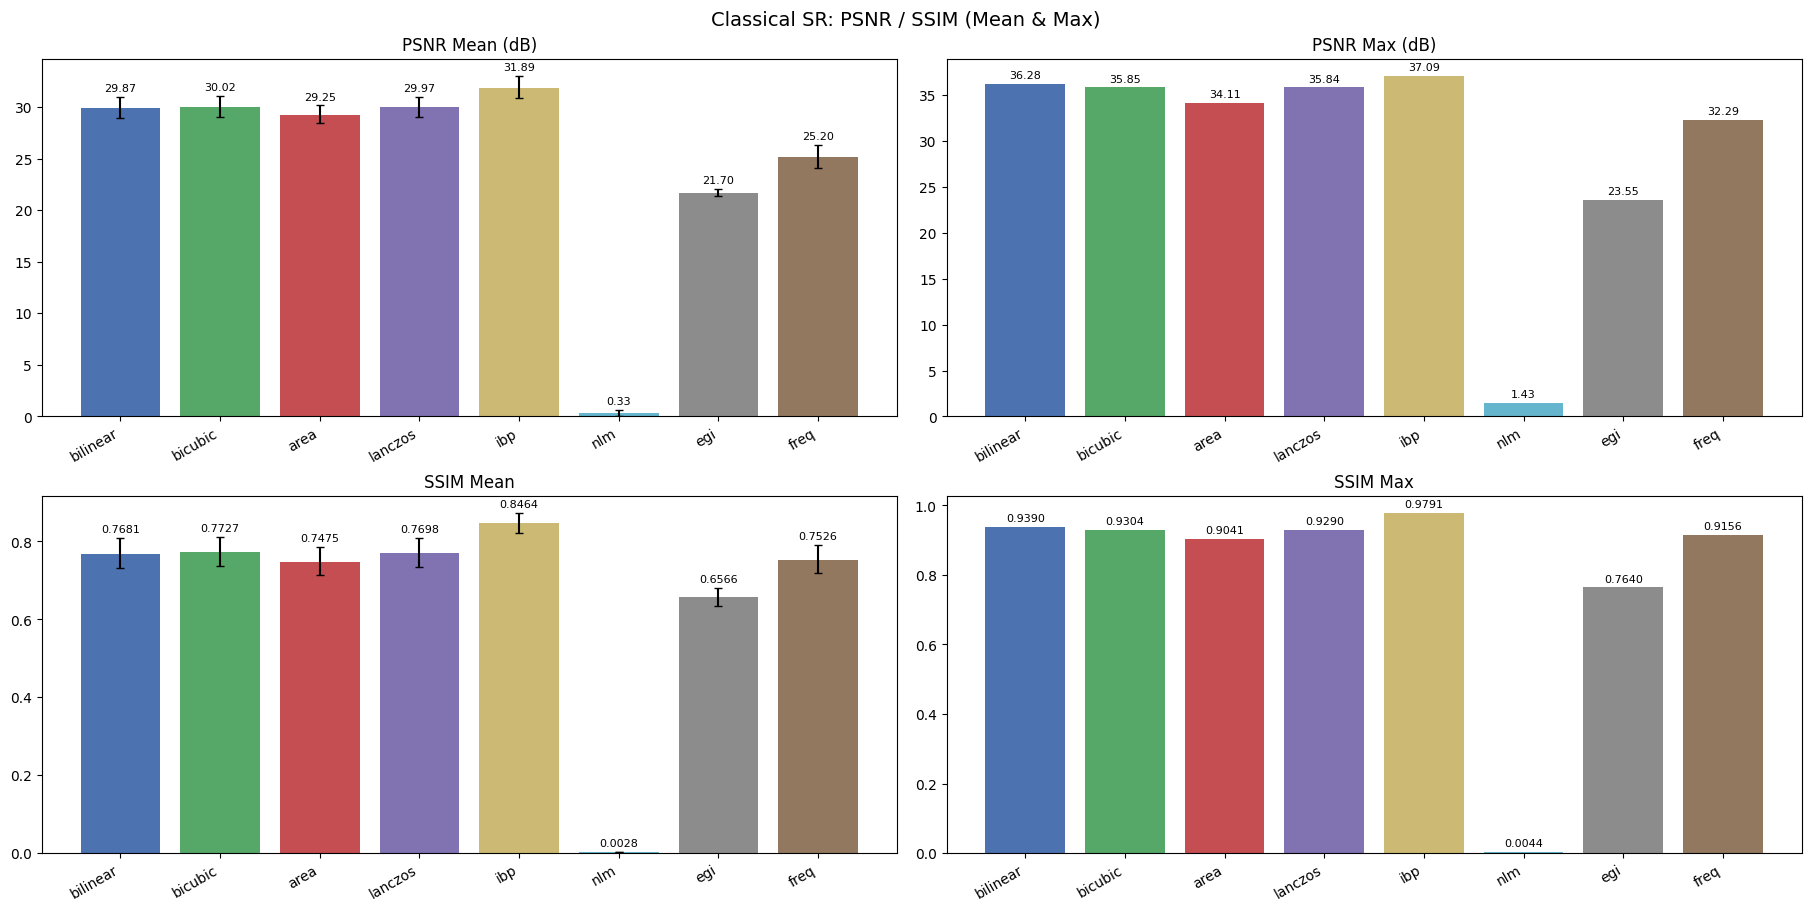

In [7]:
plot_psnr_ssim_panels(
    metric_summary=metric_summary,
    algorithms_order=algorithms,
    colors_map=colors,
    main_title='Classical SR: PSNR / SSIM (Mean & Max)',
    outfile=RESULTS_DIR / 'psnr_ssim_summary.png',
    figsize=(18, 9)
)

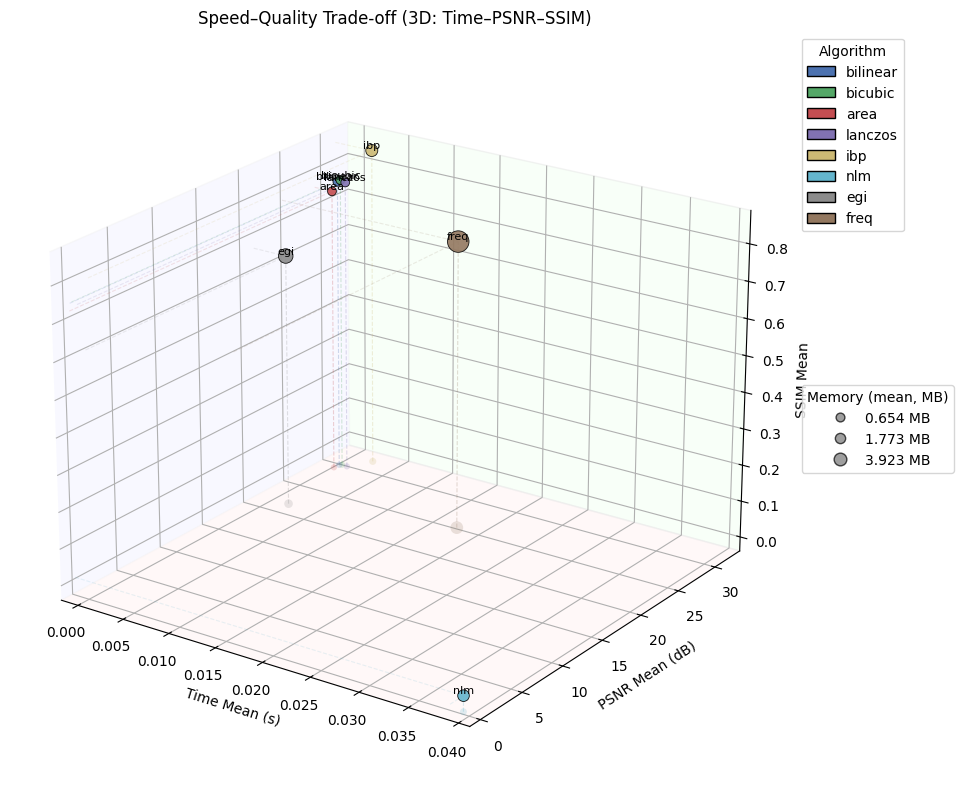

In [13]:
plot_speed_quality_tradeoff_3d(
    metric_summary=metric_summary,
    algorithms=algorithms,
    colors=colors,
    results_dir=RESULTS_DIR,
    save=True,
    figsize=(10, 8),
    view=(22, -55),
)

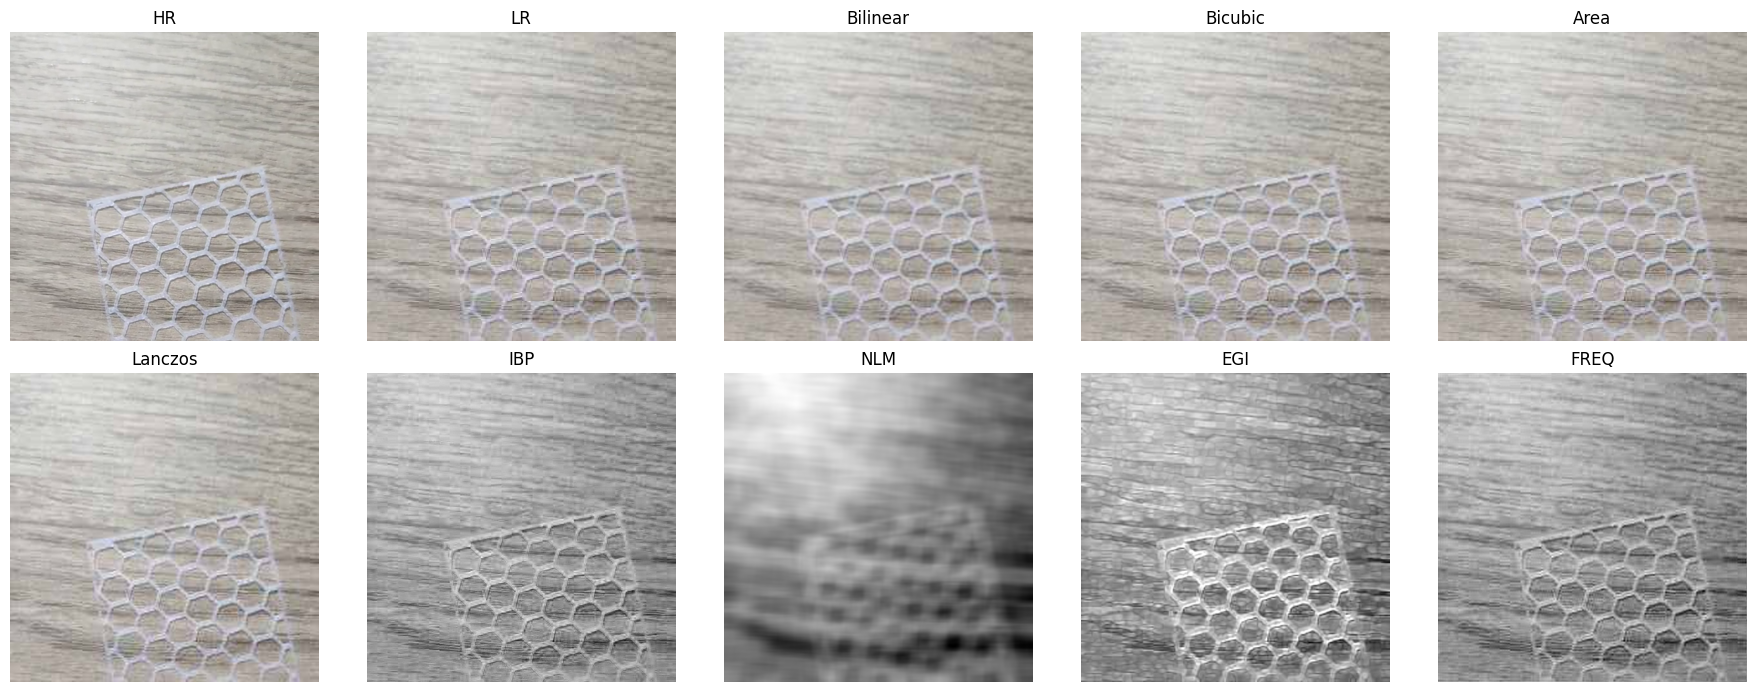

In [8]:
hr_img_v, lr_img_v, bilinear_v, bicubic_v, area_v, lanczos_v = vis
hr_g_v, lr_g_v, ibp_v = ibp_example
hr_v, nlm_v = nlm_example
hr_egi_v, lr_egi_v, egi_v = egi_example
hr_freq_v, freq_v = freq_example

def to_display(img):
    if img.ndim == 2:
        return img if img.dtype != np.float32 else np.clip(img,0,1)
    return img

images = [
    ('HR', hr_img_v),
    ('LR', lr_img_v),
    ('Bilinear', bilinear_v),
    ('Bicubic', bicubic_v),
    ('Area', area_v),
    ('Lanczos', lanczos_v),
    ('IBP', ibp_v),
    ('NLM', nlm_v if nlm_v.ndim==3 else nlm_v),
    ('EGI', egi_v),
    ('FREQ', freq_v),
]

plt.figure(figsize=(18,7))

for i, (title, img) in enumerate(images, start=1):
    plt.subplot(2,5,i)
    cmap = 'gray' if img.ndim==2 else None
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
out_grid = RESULTS_DIR / 'super_resolution_example.png'
plt.savefig(out_grid, dpi=150)

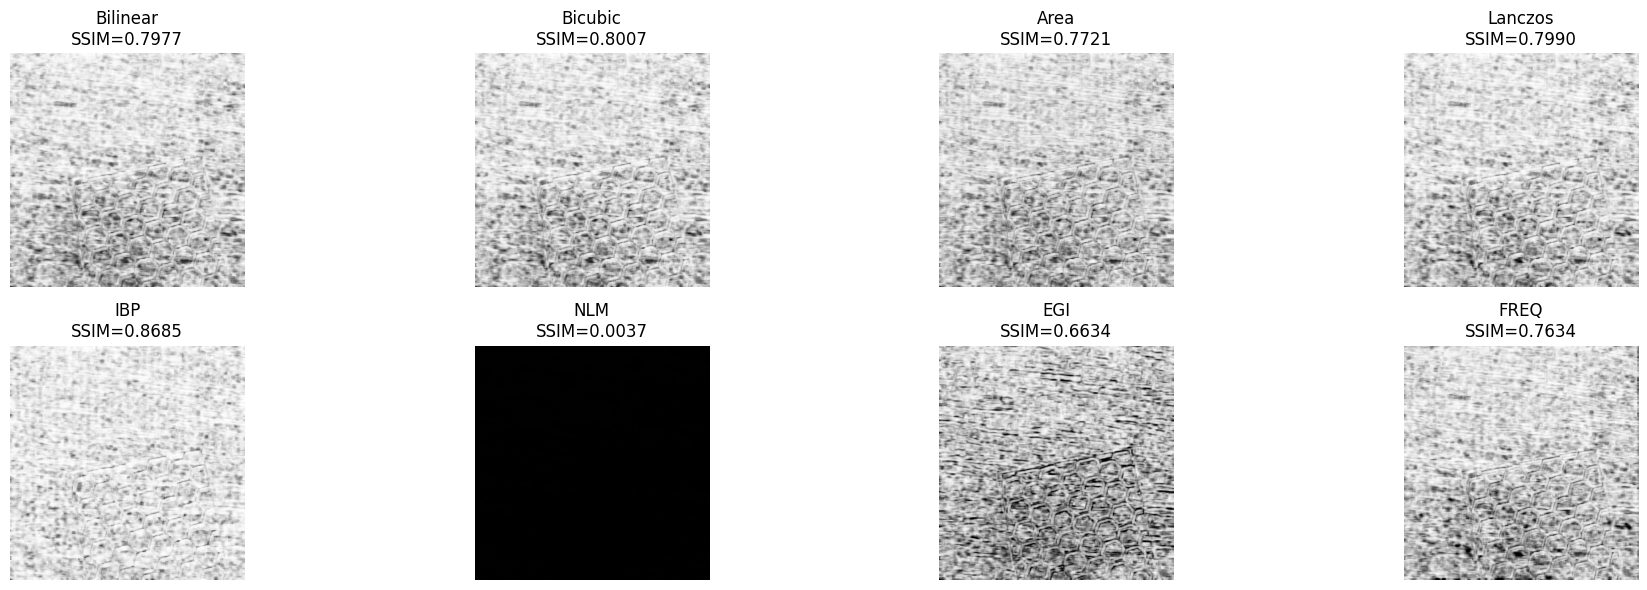

In [9]:
def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) if img.ndim == 3 else img

hr_img_v, lr_img_v, bilinear_v, bicubic_v, area_v, lanczos_v = vis
hr_g_v, lr_g_v, ibp_v = ibp_example
hr_v, nlm_v = nlm_example
hr_egi_v, lr_egi_v, egi_v = egi_example
hr_freq_v, freq_v = freq_example

# Lista completa de pares (nombre, HR, SR) en el orden requerido
pairs = [
    ('Bilinear', to_gray(hr_img_v), to_gray(bilinear_v)),
    ('Bicubic',  to_gray(hr_img_v), to_gray(bicubic_v)),
    ('Area',     to_gray(hr_img_v), to_gray(area_v)),
    ('Lanczos',  to_gray(hr_img_v), to_gray(lanczos_v)),
    ('IBP',      hr_g_v, ibp_v),
    ('NLM',      hr_v, nlm_v if nlm_v.ndim==2 else cv2.cvtColor(nlm_v, cv2.COLOR_RGB2GRAY)),
    ('EGI',      hr_egi_v, egi_v),
    ('FREQ',     hr_freq_v, freq_v),
]

ssim_maps = []
titles = []
for name, hr_g, sr_g in pairs:
    data_range = 255 if hr_g.dtype != np.float32 else 1.0
    val, ssim_map = ssim(hr_g, sr_g, data_range=data_range, full=True)
    ssim_maps.append((ssim_map, val))
    titles.append(name)

plt.figure(figsize=(20,6))
for i, ((ssim_map, val), name) in enumerate(zip(ssim_maps, titles), start=1):
    plt.subplot(2,4,i)
    plt.imshow(ssim_map, cmap='gray', vmin=0, vmax=1)
    plt.title(f"{name}\nSSIM={val:.4f}")
    plt.axis('off')
plt.tight_layout()
out_diff = RESULTS_DIR / 'ssim_similarity_maps.png'
plt.savefig(out_diff, dpi=150)

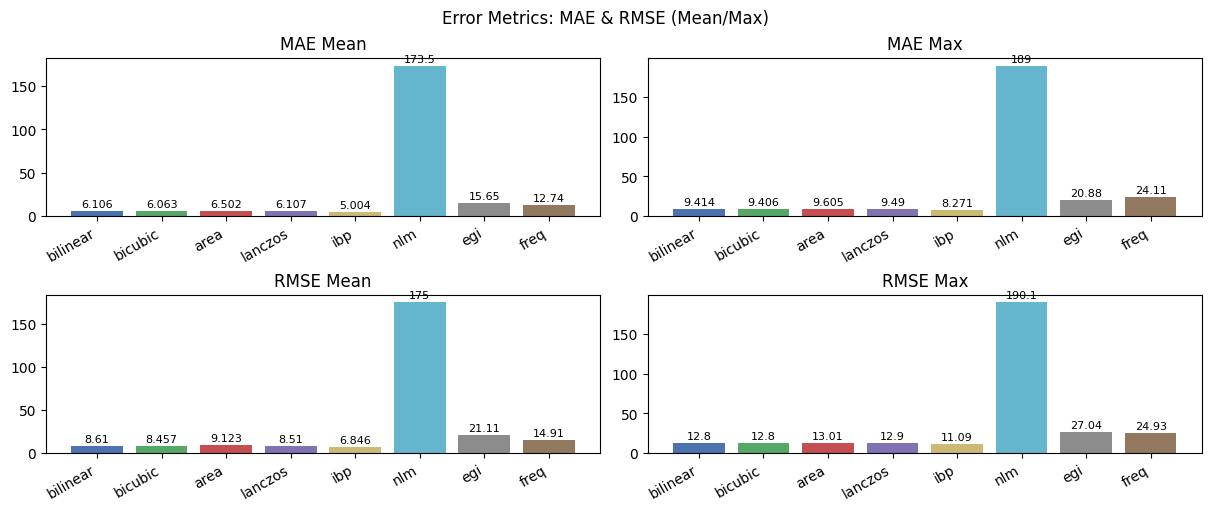

In [18]:
def plot_error_metrics_grid(metric_summary, algorithms, colors, results_dir=None, figsize=(14, 8)):
    """
    Display and save a 2x2 grid with MAE/RMSE mean and max across algorithms.

    Panels (row-major):
      [0,0] MAE Mean
      [0,1] MAE Max
      [1,0] RMSE Mean
      [1,1] RMSE Max
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path

    # Collect values
    mae_mean = [metric_summary[a].get('mae_mean', np.nan) for a in algorithms]
    rmse_mean = [metric_summary[a].get('rmse_mean', np.nan) for a in algorithms]

    # Try to get max from summary, else fallback to raw stats if available
    mae_max = []
    rmse_max = []
    for a in algorithms:
        # MAE max
        val_mae_max = metric_summary[a].get('mae_max', np.nan)
        if not np.isfinite(val_mae_max):
            try:
                vals = mae_stats.get(a, [])  # from notebook global state
                val_mae_max = float(np.max(vals)) if len(vals) else np.nan
            except Exception:
                val_mae_max = np.nan
        mae_max.append(val_mae_max)

        # RMSE max
        val_rmse_max = metric_summary[a].get('rmse_max', np.nan)
        if not np.isfinite(val_rmse_max):
            try:
                vals = rmse_stats.get(a, [])  # from notebook global state
                val_rmse_max = float(np.max(vals)) if len(vals) else np.nan
            except Exception:
                val_rmse_max = np.nan
        rmse_max.append(val_rmse_max)

    def _bar(ax, data, title, fmt='{:.4g}'):
        x = np.arange(len(algorithms))
        bars = ax.bar(x, data, color=[colors[a] for a in algorithms])
        ax.set_title(title)
        ax.set_xticks(x)
        ax.set_xticklabels(algorithms, rotation=30, ha='right')
        # annotate
        bottom, top = ax.get_ylim()
        span = top - bottom if np.isfinite(top - bottom) and (top - bottom) > 0 else 1.0
        pad = 0.01 * span
        ymax = -np.inf
        for rect, val in zip(bars, data):
            if not np.isfinite(val):
                continue
            y = rect.get_height() + pad
            ax.text(rect.get_x() + rect.get_width()/2, y, fmt.format(val), ha='center', va='bottom', fontsize=8)
            ymax = max(ymax, y)
        if np.isfinite(ymax) and ymax > ax.get_ylim()[1]:
            bottom, _ = ax.get_ylim()
            ax.set_ylim(top=ymax + max(0.02 * (ymax - bottom), 0.02))

    fig, axes = plt.subplots(2, 2, figsize=figsize, constrained_layout=True)
    _bar(axes[0,0], mae_mean, 'MAE Mean') # Lower is better
    _bar(axes[0,1], mae_max,  'MAE Max') # Lower is better
    _bar(axes[1,0], rmse_mean,'RMSE Mean') # Lower is better
    _bar(axes[1,1], rmse_max, 'RMSE Max') # Lower is better

    fig.suptitle('Error Metrics: MAE & RMSE (Mean/Max)')
    if results_dir is not None:
        try:
            out = Path(results_dir) / 'error_metrics_mae_rmse.png'
            fig.savefig(out, dpi=150, bbox_inches='tight')
        except Exception:
            pass
    plt.show()
    
plot_error_metrics_grid(
    metric_summary=metric_summary,
    algorithms=algorithms,
    colors=colors,
    results_dir=RESULTS_DIR,
    figsize=(12, 5)
)

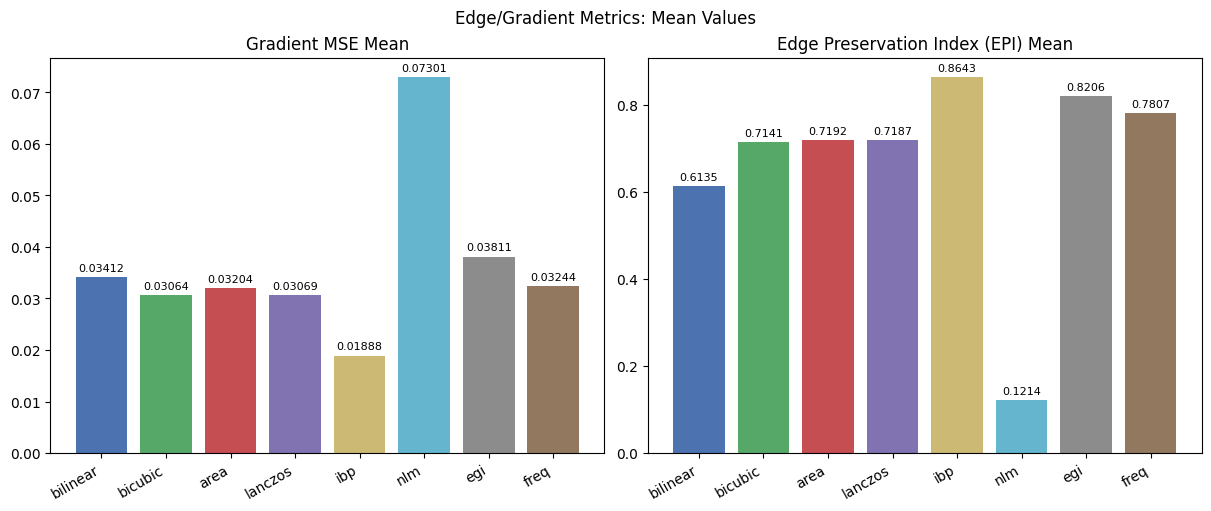

In [19]:
def plot_edge_metrics_grid(metric_summary, algorithms, colors, results_dir=None, figsize=(12, 5)):
    """
    Display and save a 1x2 grid with mean values of Gradient MSE and EPI across algorithms.

    Panels:
      [0] Gradient MSE Mean (lower is better)
      [1] Edge Preservation Index (EPI) Mean (≈1 is ideal)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path

    grad_mse_mean = [metric_summary[a].get('grad_mse_mean', np.nan) for a in algorithms]
    epi_mean = [metric_summary[a].get('epi_mean', np.nan) for a in algorithms]

    def _bar(ax, data, title, fmt='{:.4g}'):
        x = np.arange(len(algorithms))
        bars = ax.bar(x, data, color=[colors[a] for a in algorithms])
        ax.set_title(title)
        ax.set_xticks(x)
        ax.set_xticklabels(algorithms, rotation=30, ha='right')
        bottom, top = ax.get_ylim()
        span = top - bottom if np.isfinite(top - bottom) and (top - bottom) > 0 else 1.0
        pad = 0.01 * span
        ymax = -np.inf
        for rect, val in zip(bars, data):
            if not np.isfinite(val):
                continue
            y = rect.get_height() + pad
            ax.text(rect.get_x() + rect.get_width()/2, y, fmt.format(val), ha='center', va='bottom', fontsize=8)
            ymax = max(ymax, y)
        if np.isfinite(ymax) and ymax > ax.get_ylim()[1]:
            bottom, _ = ax.get_ylim()
            ax.set_ylim(top=ymax + max(0.02 * (ymax - bottom), 0.02))

    fig, axes = plt.subplots(1, 2, figsize=figsize, constrained_layout=True)
    _bar(axes[0], grad_mse_mean, 'Gradient MSE Mean') # Lower values are better
    _bar(axes[1], epi_mean, 'Edge Preservation Index (EPI) Mean') # Values closer to 1 are better

    fig.suptitle('Edge/Gradient Metrics: Mean Values')
    if results_dir is not None:
        try:
            out = Path(results_dir) / 'edge_gradient_metrics_mean.png'
            fig.savefig(out, dpi=150, bbox_inches='tight')
        except Exception:
            pass
    plt.show()
    
plot_edge_metrics_grid(
    metric_summary=metric_summary,
    algorithms=algorithms,
    colors=colors,
    results_dir=RESULTS_DIR,
    figsize=(12, 5)
)

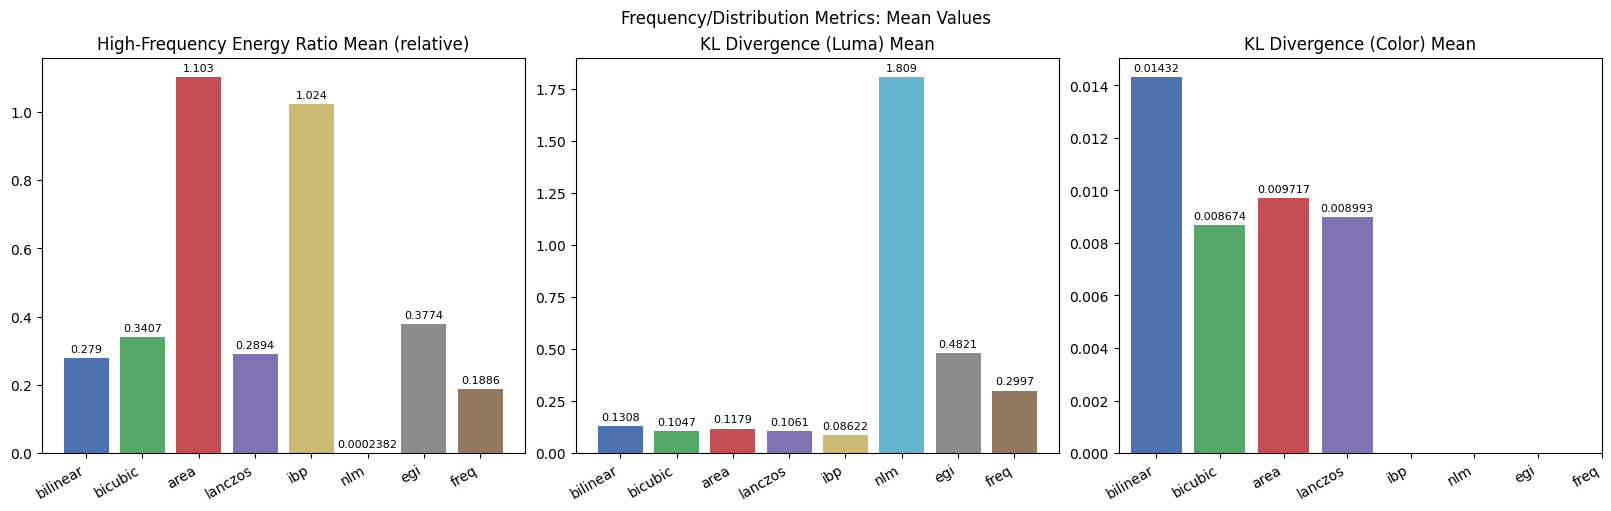

In [20]:
def plot_frequency_distribution_metrics_grid(metric_summary, algorithms, colors, results_dir=None, figsize=(16, 5)):
    """
    Display and save a 1x3 grid with mean values of:
      - HF Energy Ratio mean (relative)
      - KL Luma mean
      - KL Color mean (may be NaN for grayscale-only methods)
    across algorithms.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path

    hf_ratio_mean = [metric_summary[a].get('hf_ratio_mean', np.nan) for a in algorithms]
    kl_luma_mean = [metric_summary[a].get('kl_luma_mean', np.nan) for a in algorithms]
    kl_color_mean = [metric_summary[a].get('kl_color_mean', np.nan) for a in algorithms]

    def _bar(ax, data, title, fmt='{:.4g}'):
        x = np.arange(len(algorithms))
        bars = ax.bar(x, data, color=[colors[a] for a in algorithms])
        ax.set_title(title)
        ax.set_xticks(x)
        ax.set_xticklabels(algorithms, rotation=30, ha='right')
        bottom, top = ax.get_ylim()
        span = top - bottom if np.isfinite(top - bottom) and (top - bottom) > 0 else 1.0
        pad = 0.01 * span
        ymax = -np.inf
        for rect, val in zip(bars, data):
            if not np.isfinite(val):
                continue
            y = rect.get_height() + pad
            ax.text(rect.get_x() + rect.get_width()/2, y, fmt.format(val), ha='center', va='bottom', fontsize=8)
            ymax = max(ymax, y)
        if np.isfinite(ymax) and ymax > ax.get_ylim()[1]:
            bottom, _ = ax.get_ylim()
            ax.set_ylim(top=ymax + max(0.02 * (ymax - bottom), 0.02))

    fig, axes = plt.subplots(1, 3, figsize=figsize, constrained_layout=True)
    _bar(axes[0], hf_ratio_mean, 'High-Frequency Energy Ratio Mean (relative)')
    _bar(axes[1], kl_luma_mean, 'KL Divergence (Luma) Mean') # Lower is better
    _bar(axes[2], kl_color_mean, 'KL Divergence (Color) Mean') # Lower is better

    fig.suptitle('Frequency/Distribution Metrics: Mean Values')
    if results_dir is not None:
        try:
            out = Path(results_dir) / 'freq_distribution_metrics_mean.png'
            fig.savefig(out, dpi=150, bbox_inches='tight')
        except Exception:
            pass
    plt.show()
    
plot_frequency_distribution_metrics_grid(
    metric_summary=metric_summary,
    algorithms=algorithms,
    colors=colors,
    results_dir=RESULTS_DIR,
    figsize=(16, 5)
)

In [17]:
def show_algorithm_ranking(metric_summary, maximize=None, minimize=None, weights=None):
    """
    Compute and display ranking using rank_algorithms(summary, maximize, minimize, weights).

    Prints the ranked list and returns it along with raw scores and bounds.
    """
    ranked, scores, bounds = rank_algorithms(
        summary=metric_summary, maximize=maximize, minimize=minimize, weights=weights
    )
    print('Ranking (best to worst):')
    for i, (alg, score) in enumerate(ranked, start=1):
        print(f'{i:2d}. {alg:10s}  score={score:.4f}')
    return ranked, scores, bounds

show_algorithm_ranking(
    metric_summary=metric_summary,
    maximize=['psnr_mean', 'ssim_mean'],
    minimize=['time_mean', 'memory_mean', 'mae_mean', 'rmse_mean', 'grad_mse_mean', 'kl_luma_mean', 'kl_color_mean'],
    weights={
        'psnr_mean': 0.25,
        'ssim_mean': 0.25,
        'time_mean': 0.15,
        'memory_mean': 0.10,
        'mae_mean': 0.05,
        'rmse_mean': 0.05,
        'grad_mse_mean': 0.05,
        'kl_luma_mean': 0.05,
        'kl_color_mean': 0.05,
    }
)

Ranking (best to worst):
 1. bicubic     score=0.9502
 2. lanczos     score=0.9436
 3. area        score=0.9264
 4. ibp         score=0.9244
 5. bilinear    score=0.8943
 6. egi         score=0.7353
 7. freq        score=0.6791
 8. nlm         score=0.0851


([('bicubic', 0.9501834166098307),
  ('lanczos', 0.9436329785254537),
  ('area', 0.9263679986320776),
  ('ibp', 0.9243605556103616),
  ('bilinear', 0.894333142349885),
  ('egi', 0.7352649753567925),
  ('freq', 0.6790970919941417),
  ('nlm', 0.08511934223219125)],
 {'bilinear': 0.894333142349885,
  'bicubic': 0.9501834166098307,
  'area': 0.9263679986320776,
  'lanczos': 0.9436329785254537,
  'ibp': 0.9243605556103616,
  'nlm': 0.08511934223219125,
  'egi': 0.7352649753567925,
  'freq': 0.6790970919941417},
 {'psnr_mean': (0.3317270263627584, 31.890650586614193),
  'ssim_mean': (0.0028353306166376754, 0.8464086428585035),
  'time_mean': (9.52533333475003e-05, 0.03914960000026137),
  'memory_mean': (685549.6, 16452661.533333333),
  'mae_mean': (5.004497782389323, 173.5163599650065),
  'rmse_mean': (6.846458612528905, 174.97536493847522),
  'grad_mse_mean': (0.01888210386969149, 0.07301454835881789),
  'kl_luma_mean': (0.08621589536085408, 1.8087523021975387),
  'kl_color_mean': (0.008673